In [15]:
import model
import os
from option import args
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import data
import utils
import numpy as np

import h5py
loaded = {}
loaded_gt ={}

path,tot = "",""


def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    act_ids = []
    for i in ids:
        name = path['3T'][i]['h5']
        if(not os.path.isfile(name)):
            continue
        res_vol = h5py.File(name, 'r')
        
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:] }
        
        name = path['7T'][i]['GT']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:] }
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        
        if(not os.path.isfile(name)):
            continue
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()
        act_ids.append(i)
    return act_ids

In [2]:
load_dir = "experiment/DTIArbNet/work"

In [3]:
os.listdir(load_dir)

['model_best_40_epoch,50_vols,20_test_vols,blk_(32, 32, 4),loss_0.5*MSE+0.5*L1,growth_32.pt',
 'model_best_40_epoch,50_vols,20_test_vols,blk_(32, 32, 4),loss_1*MSE,growth_32.pt',
 'model_best_40_epoch,50_vols,20_test_vols,blk_(32, 32, 4),loss_1*L1,growth_32.pt']

In [4]:
load_model_pt = "model_best_40_epoch,50_vols,20_test_vols,blk_(32, 32, 4),loss_1*MSE,growth_32.pt"

In [5]:
ids = utils.get_ids()
ids.sort()
offset = 50
args.no_vols = 10
args.growth=32
args.test_vols = 2
total_vols = args.no_vols+args.test_vols
temp = ids[:args.no_vols]
temp.extend(ids[offset:args.test_vols+offset])
ids = temp

In [6]:
ids

['100610',
 '102311',
 '102816',
 '104416',
 '105923',
 '108323',
 '109123',
 '111312',
 '111514',
 '114823',
 '172130',
 '173334']

In [7]:
curr_model = model.Model(args)

Making model...


In [8]:
curr_model.load(os.path.join(load_dir,load_model_pt))

load from model_experiment/DTIArbNet/work/model_best_40_epoch,50_vols,20_test_vols,blk_(32, 32, 4),loss_1*MSE,growth_32.pt.pt


In [9]:
loader = data.Data(args,ids= ids)

[1.2, 1.2, 1.2]
Loading Done


In [10]:
loader.rebuild(blk_size = (32,32,4),type = "train",stable = False)

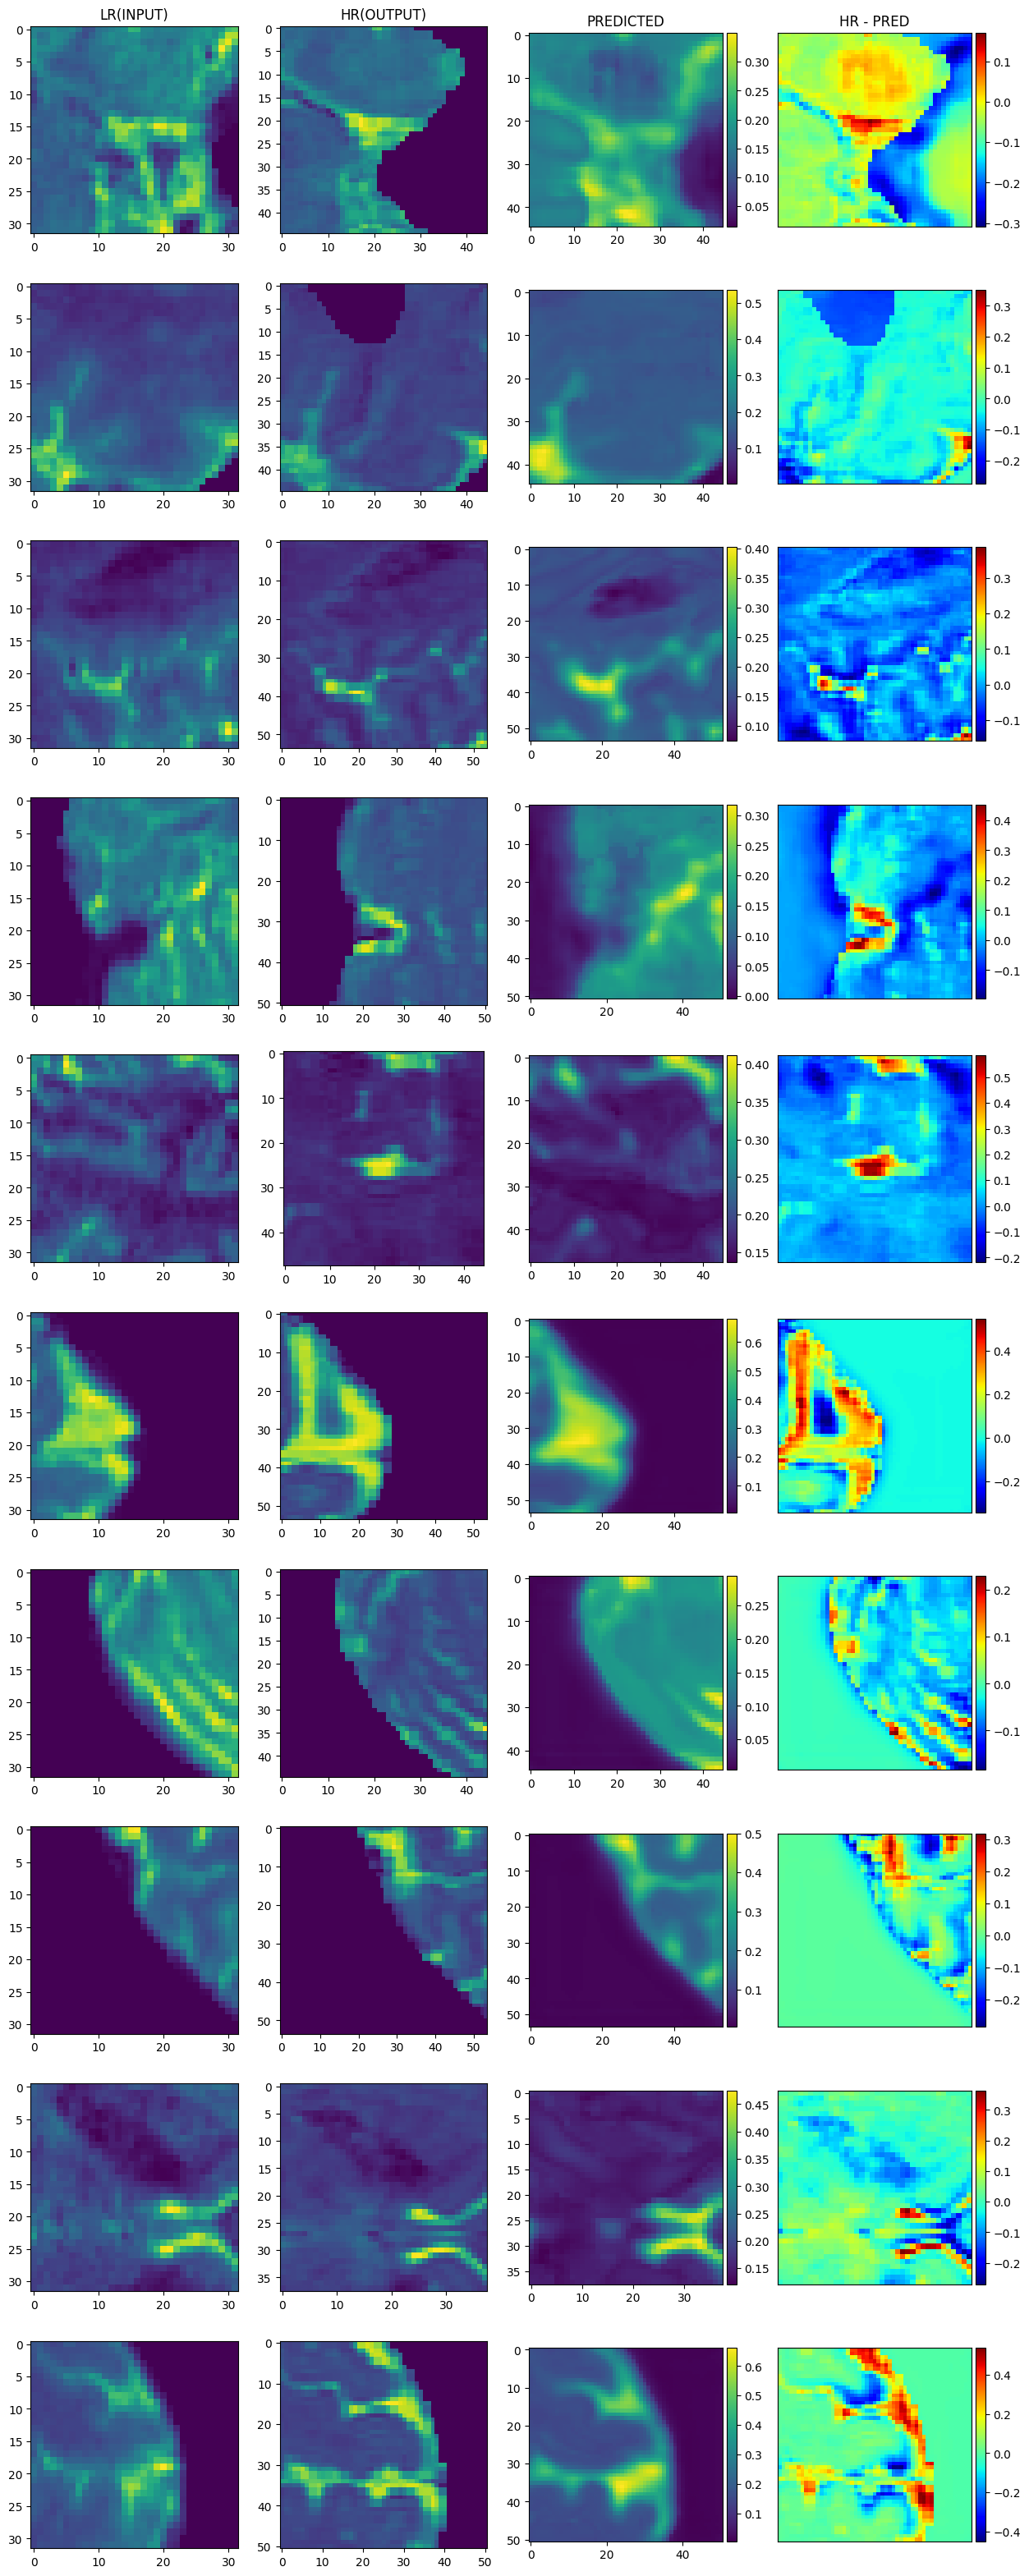

In [102]:
samples = 10
fig, ax = plt.subplots(samples,4)

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*samples)
 
# set width of each subplot as 8
fig.set_figwidth(15)
ax[0][0].set_title("LR(INPUT)")
ax[0][1].set_title("HR(OUTPUT)")
ax[0][2].set_title("PREDICTED")
ax[0][3].set_title("HR - PRED")
for i in range(samples):
    temp = next(iter(loader.training_data))
    ax[i][0].imshow(temp[0][0,:,:,0,0])
    ax[i][1].imshow(temp[1][0,:,:,0,0])
    lr_tensor = torch.permute(temp[0], (0,4,1,2,3)).to('cuda')
    pred = curr_model.forward(lr_tensor,temp[2])
    pred = torch.permute(pred, (0,2,3,4,1)).float()
    pred = pred[0,:,:,0,0].cpu().detach().numpy()
    im = ax[i][2].imshow(pred)
    divider = make_axes_locatable(ax[i][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    im = ax[i][3].imshow(temp[1][0,:,:,0,0] - pred,cmap='jet')
    ax[i][3].tick_params(left = False, right = False , labelleft = False , 
            labelbottom = False, bottom = False) 
    divider = make_axes_locatable(ax[i][3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

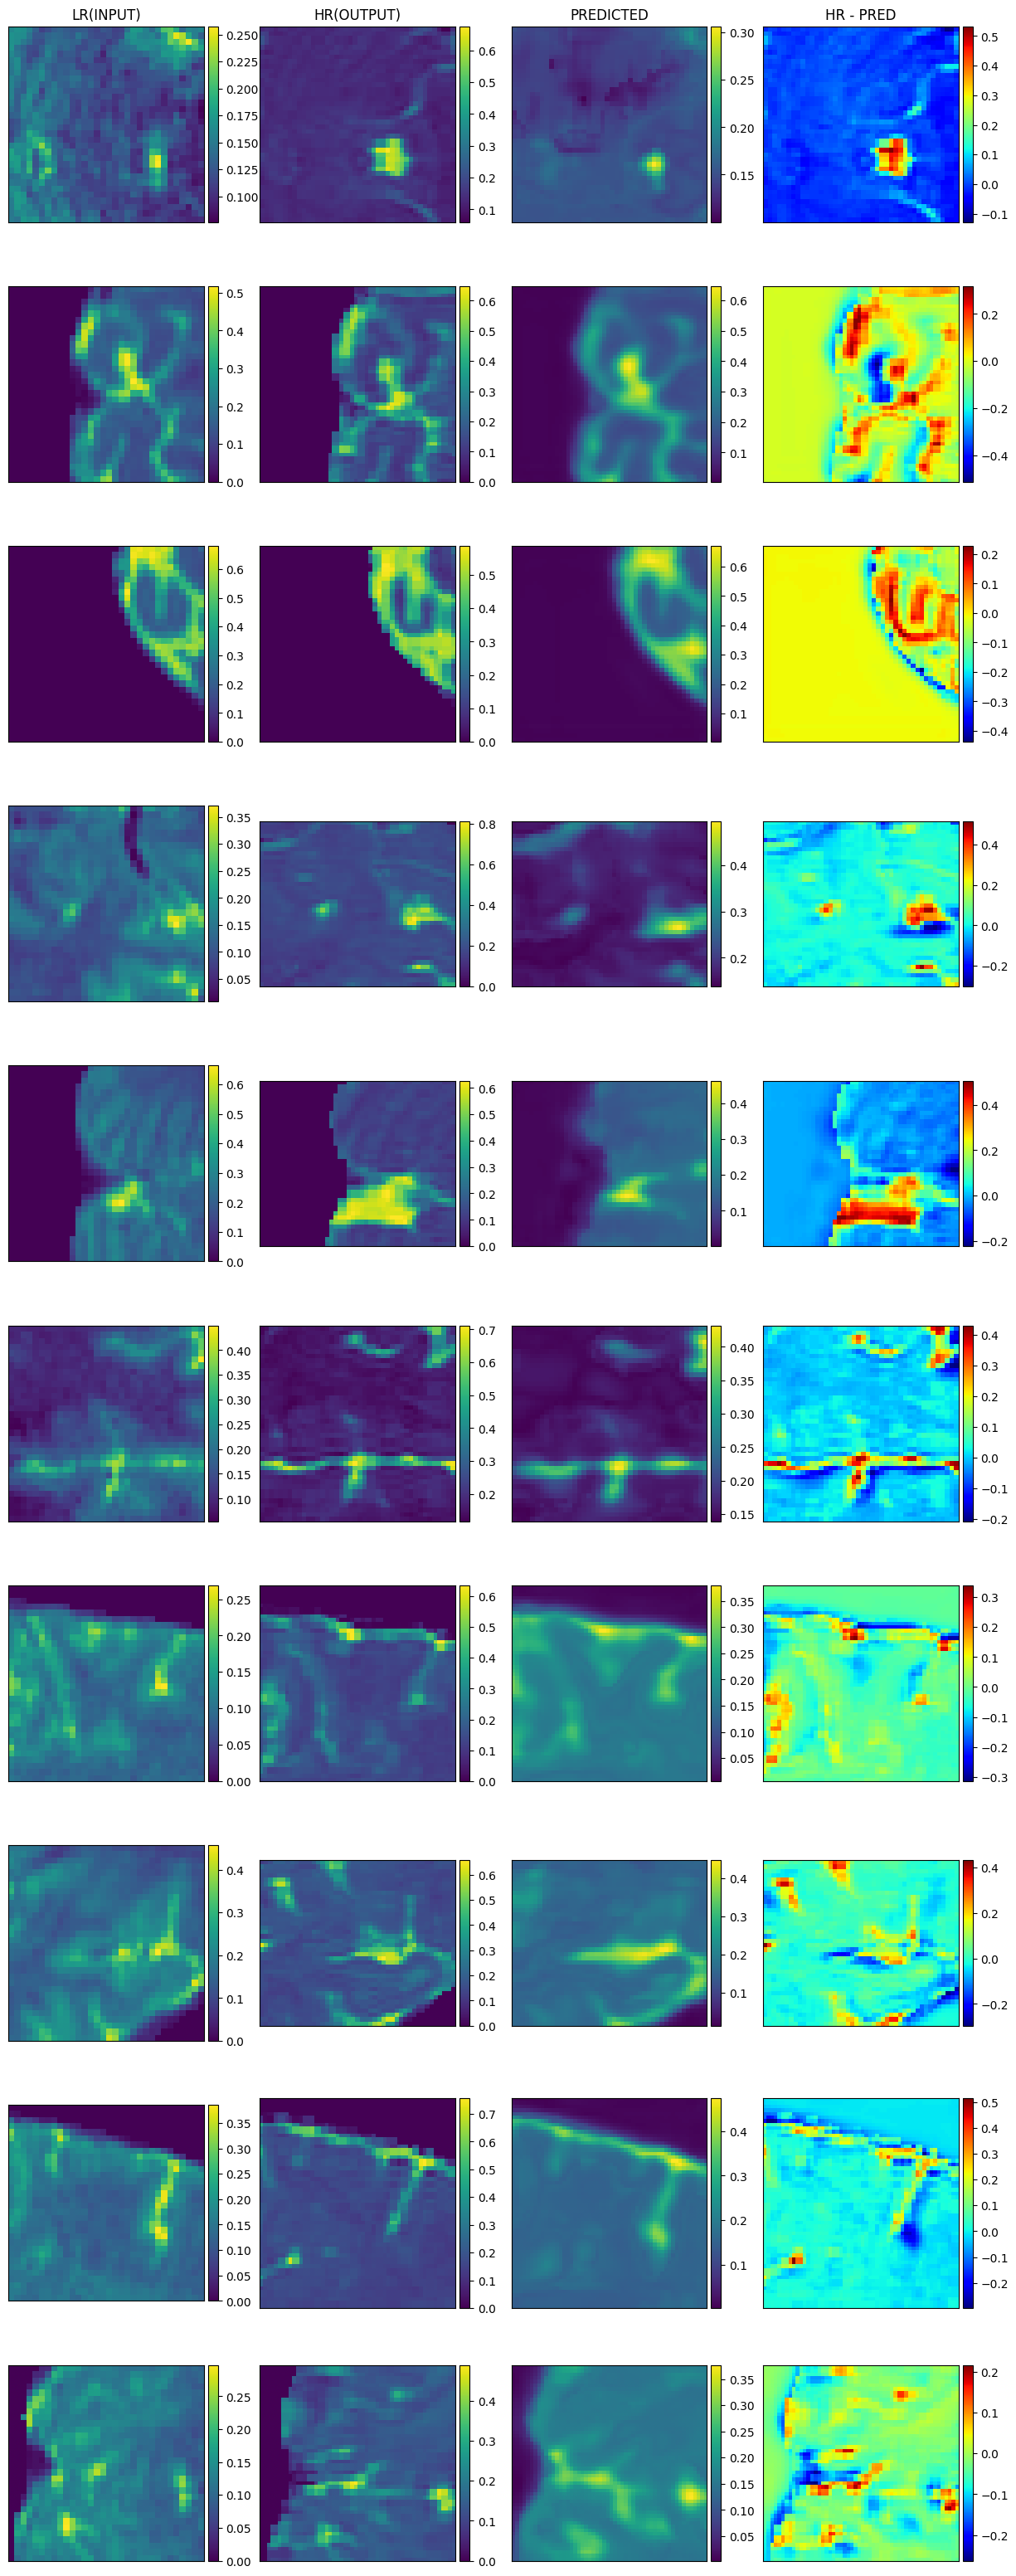

In [106]:
samples = 10
fig, ax = plt.subplots(samples,4)

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*samples)
 
# set width of each subplot as 8
fig.set_figwidth(15)
ax[0][0].set_title("LR(INPUT)")
ax[0][1].set_title("HR(OUTPUT)")
ax[0][2].set_title("PREDICTED")
ax[0][3].set_title("HR - PRED")
for i in range(samples):
    temp = next(iter(loader.training_data))
    buf = {}
    buf[0] = temp[0][0,:,:,0,0]
    buf[1] = temp[1][0,:,:,0,0]
    
    lr_tensor = torch.permute(temp[0], (0,4,1,2,3)).to('cuda')
    pred = curr_model.forward(lr_tensor,temp[2])
    pred = torch.permute(pred, (0,2,3,4,1)).float()
    
    buf[2] = pred[0,:,:,0,0].cpu().detach().numpy()
    buf[3] = temp[1][0,:,:,0,0] - pred[0,:,:,0,0].cpu().detach().numpy()
    
    for j in range(4):
        if(j == 3):
            im = ax[i][j].imshow(buf[j],cmap='jet')
        else:
            im = ax[i][j].imshow(buf[j])
        divider = make_axes_locatable(ax[i][j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax[i][j].tick_params(left = False, right = False , labelleft = False , 
            labelbottom = False, bottom = False) 
        

In [105]:
def recon(lr_tensor,hr_tensor,pnts):
    num_blk = lr_tensor.shape[0]
    vol = torch.empty(size=hr_tensor.shape)
    with torch.no_grad():
        for ii in range(num_blk):
            tm = lr_tensor[ii,...]
            tm = tm.unsqueeze(0)
            pred = curr_model.forward(tm,scale)
            pred = torch.permute(pred, (0,2,3,4,1)).float()
            vol[pnts[ii][0]:pnts[ii][1]+1,pnts[ii][2]:pnts[ii][3]+1,pnts[ii][4]:pnts[ii][5]+1,...] = pred[0,...]
    return vol

In [90]:
for iteration, (lr_tensor, hr_tensor,pnts,scale) in enumerate(loader.testing_data, 1):
    lr_tensor = lr_tensor.to('cuda')
    hr_tensor = hr_tensor.to('cuda')
    lr_tensor = torch.permute(lr_tensor, (0,4,1,2,3))
    
    vol = recon(lr_tensor,hr_tensor,pnts)

            
    break

In [91]:
vol.shape

torch.Size([232, 261, 232, 5])

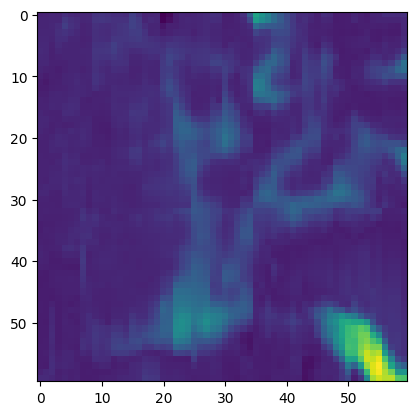

In [22]:
plt.imshow(vol[80,:,:,0][40:100,40:100])

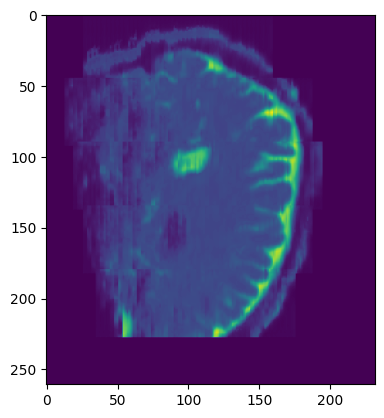

In [92]:
plt.imshow(vol[80,:,:,0])

In [67]:
scale = (1.2,1.2,1.2)
temp = loaded['172130']['vol0']
temp = temp[np.newaxis,...]
temp = torch.from_numpy(temp)

temp = torch.permute(temp, (0,4,1,2,3))
temp = temp.to('cuda')

In [68]:
temp.shape

torch.Size([1, 7, 145, 174, 145])

In [69]:
scale

(1.2, 1.2, 1.2)

In [73]:
loaded_gt['172130']['ADC'].shape

(173, 207, 173, 1)

In [74]:
tmp = temp[:,:,20:84,20:84,60:64]

In [75]:
tmp.shape

torch.Size([1, 7, 64, 64, 4])

In [76]:
scale

(1.2, 1.2, 1.2)

In [82]:
o = curr_model.forward(tmp,scale)
o = torch.permute(o, (0,2,3,4,1)).float()

In [83]:
o.shape

torch.Size([1, 77, 77, 5, 5])

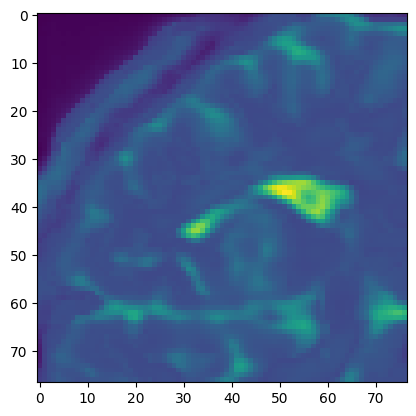

In [84]:
plt.imshow(o[0,:,:,2,0].cpu().detach().numpy())

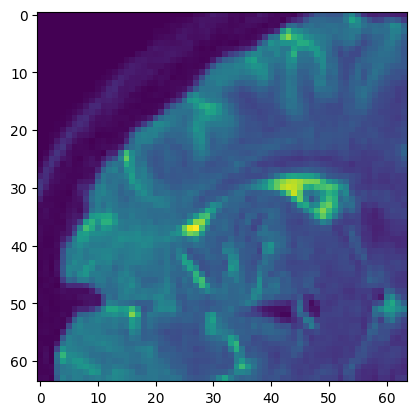

In [88]:
plt.imshow(temp[0,0,20:84,20:84,62].cpu().detach().numpy())

In [86]:
temp[0,0,20:84,20:84,60:64].shape

torch.Size([64, 64, 4])

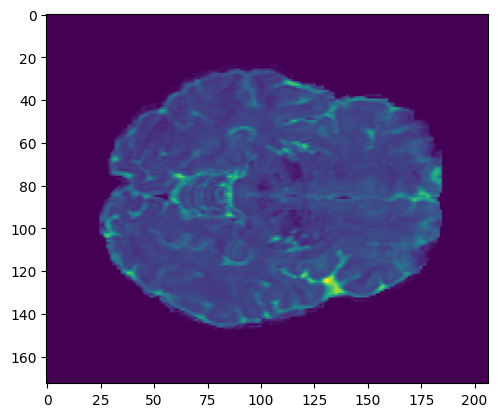

In [80]:
plt.imshow(loaded_gt['172130']['ADC'][:,:,62:63,0])